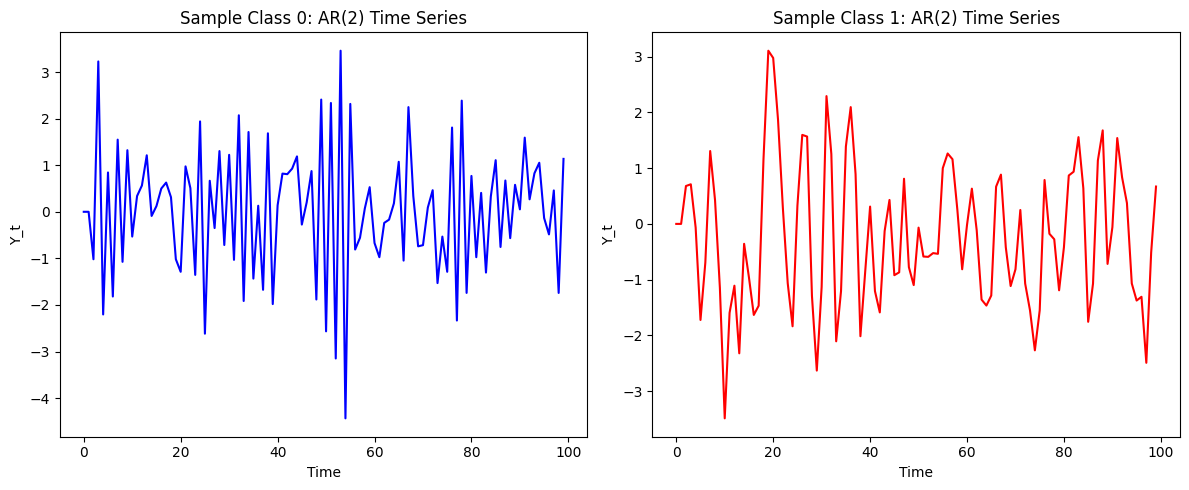

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

num_series = 500
length = 100
noise_std = 1.0

# AR(2) coefficients for each class
ar_coef_class0 = [-0.5, 0.25]
ar_coef_class1 = [0.75, -0.5]

def generate_ar_series(ar_coefs, length, noise_std):
    """
    Generate a single AR(p) time series with given coefficients.
    The first p values are initialized to 0.
    """
    p = len(ar_coefs)
    series = np.zeros(length)
    for t in range(p, length):
        series[t] = sum(ar_coefs[i] * series[t - i - 1] for i in range(p)) + np.random.normal(scale=noise_std)
    return series

# Generate 500 time series for each class
series_class0 = [generate_ar_series(ar_coef_class0, length, noise_std) for _ in range(num_series)]
series_class1 = [generate_ar_series(ar_coef_class1, length, noise_std) for _ in range(num_series)]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(series_class0[0], color='blue')
plt.title("Sample Class 0: AR(2) Time Series")
plt.xlabel("Time")
plt.ylabel("Y_t")

plt.subplot(1, 2, 2)
plt.plot(series_class1[100], color='red')
plt.title("Sample Class 1: AR(2) Time Series")
plt.xlabel("Time")
plt.ylabel("Y_t")

plt.tight_layout()
plt.show()



In [ ]:
!pip install iisignature

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import iisignature

# Parameters
num_series = 500  # number of time series per class
length = 100      # length of each time series
noise_std = 1.0   # standard deviation of noise Z_t
signature_level = 2  # Signature truncation level

ar_coef_class0 = [-0.5, 0.25]
ar_coef_class1 = [0.75, -0.5]

def generate_ar_series(ar_coefs, length, noise_std):
    """ Generate a single AR(2) time series """
    p = len(ar_coefs)
    series = np.zeros(length)
    for t in range(p, length):
        series[t] = sum(ar_coefs[i] * series[t - i - 1] for i in range(p)) + np.random.normal(scale=noise_std)
    return series


series_class0 = [generate_ar_series(ar_coef_class0, length, noise_std) for _ in range(num_series)]
series_class1 = [generate_ar_series(ar_coef_class1, length, noise_std) for _ in range(num_series)]

# Lead-lag transformation function:
def lead_lag_transform(series):
    """ Compute the lead-lag transformation of a time series """
    lead = np.cumsum(series)  # Cumulative sum transformation
    lag = np.insert(lead[:-1], 0, 0)  # Shifted version with an initial 0
    return np.vstack((lead, lag)).T  # Shape (length, 2)

# Compute signatures
def compute_signatures(series_list):
    """ Compute the signature of each transformed time series """
    sig_dim = iisignature.siglength(2, signature_level)
    signatures = np.zeros((len(series_list), sig_dim))

    for i, series in enumerate(series_list):
        transformed_path = lead_lag_transform(series)
        signatures[i] = iisignature.sig(transformed_path, signature_level)

    return signatures

# Compute signatures for both classes
signatures_class0 = compute_signatures(series_class0)
signatures_class1 = compute_signatures(series_class1)

# Combine data and standardize
X = np.vstack((signatures_class0, signatures_class1))
y = np.hstack((np.zeros(num_series), np.ones(num_series)))  # Class labels

# Standardization
mean_X = np.mean(X, axis=0)
std_X = np.std(X, axis=0)
X_standardized = (X - mean_X) / std_X

# Final dataset: X_standardized contains the feature set, y contains the class labels
print("Feature matrix shape:", X_standardized.shape)
print("Labels shape:", y.shape)

Feature matrix shape: (1000, 6)
Labels shape: (1000,)


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.3, random_state=42)

LASSO Coefficients: [-0.11406281  0.11692994  0.74284904  0.11464556 -0.71018229 -0.11093595]


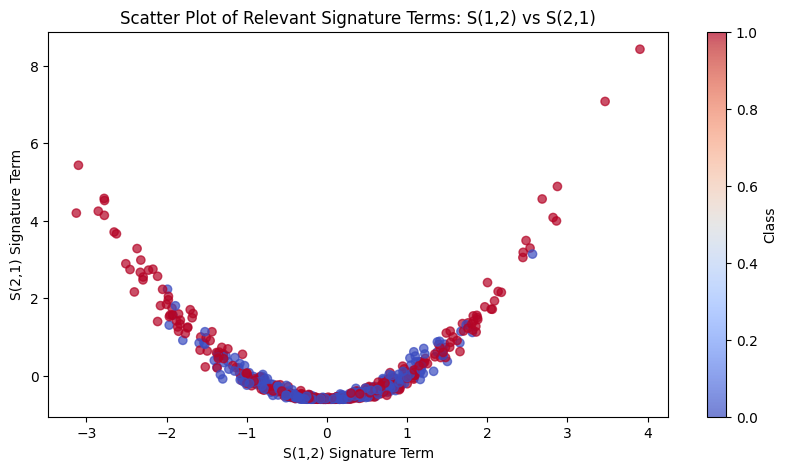

<ipython-input-25-7f4b2e715d9b>:46: RuntimeWarning: invalid value encountered in log
  plt.scatter(np.log(S_1), np.log(S_12), c=y_train, cmap='coolwarm', alpha=0.7)


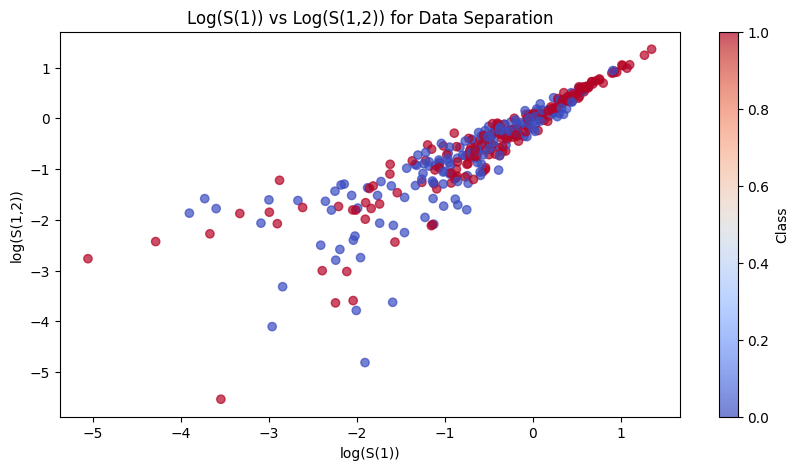

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

# X_standardized contain the signature terms S(1), S(1,2), S(2,1), etc.
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.3, random_state=42)

# Train LASSO model => find the most relevant signature terms
lasso = LassoCV(cv=5, max_iter=10000).fit(X_train, y_train)
# Get coefficients
lasso_coeffs = lasso.coef_

# Print out the LASSO coefficients to verify which features are most relevant
print(f"LASSO Coefficients: {lasso_coeffs}")

# Indicate the indices of the most relevant signature terms: (1,2) and (2,1)
# These indices would depend on the column order in your X_standardized
# Here, we assume that S(1,2) is at index 1 and S(2,1) is at index 2
s_12_index = 1
s_21_index = 2

# Get the most relevant signature terms based on LASSO coefficients
S_12 = X_train[:, s_12_index]  # S(1,2)
S_21 = X_train[:, s_21_index]  # S(2,1)

# Visualize the class separation based on S(1,2) and S(2,1)
plt.figure(figsize=(10, 5))

# Plot the points, distinguishing the classes by color
plt.scatter(S_12, S_21, c=y_train, cmap='coolwarm', alpha=0.7)
plt.xlabel('S(1,2) Signature Term')
plt.ylabel('S(2,1) Signature Term')
plt.title('Scatter Plot of Relevant Signature Terms: S(1,2) vs S(2,1)')
plt.colorbar(label='Class')
plt.show()

# Further visualization: log(S(1)) vs log(S(1,2)) for additional insight
# Assuming S(1) is at index 0
S_1 = X_train[:, 0]  # S(1)

plt.figure(figsize=(10, 5))

# Plot log(S(1)) vs log(S(1,2)) for better data separation visualization
plt.scatter(np.log(S_1), np.log(S_12), c=y_train, cmap='coolwarm', alpha=0.7)
plt.xlabel('log(S(1))')
plt.ylabel('log(S(1,2))')
plt.title('Log(S(1)) vs Log(S(1,2)) for Data Separation')
plt.colorbar(label='Class')
plt.show()

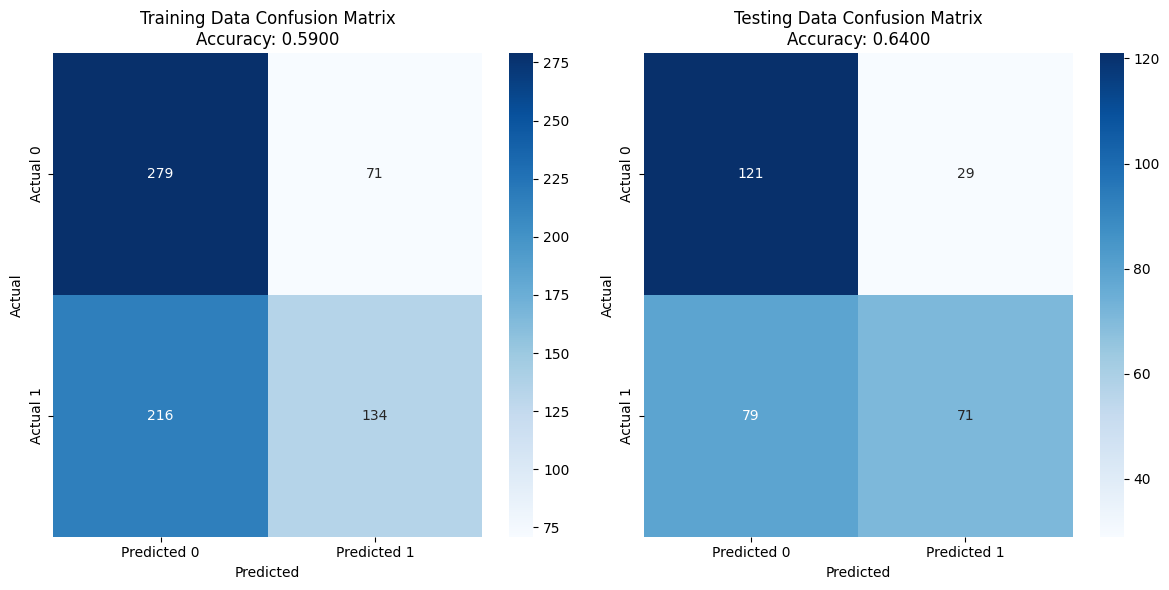

Training Data Accuracy: 0.5900
Testing Data Accuracy: 0.6400


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# We need to create our feature matrix X using the most relevant signature terms
# We will assume that the relevant signature terms (1,2) and (2,1) have non-zero coefficients from the LASSO model
# Let's assume 'X_train' and 'X_test' are the features from these signature terms

# Extract the most relevant signature terms from the LASSO model
# Here we assume lasso_coeffs[2] and lasso_coeffs[1] correspond to the (1,2) and (2,1) terms

# Create the feature matrix X using the relevant signature terms
X_train_selected = np.array([X_train[:, 1], X_train[:, 2]]).T  # Selecting S(1,2) and S(2,1) features for training
X_test_selected = np.array([X_test[:, 1], X_test[:, 2]]).T  # Selecting S(1,2) and S(2,1) features for testing

# Initialize and train the logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_selected, y_train)

# Predict on the training and testing data
y_train_pred = log_reg.predict(X_train_selected)
y_test_pred = log_reg.predict(X_test_selected)

# Confusion matrix for training data
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
accuracy_train = accuracy_score(y_train, y_train_pred)

# Confusion matrix for testing data
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

# Plot confusion matrices
plt.figure(figsize=(12, 6))

# Plot confusion matrix for training data
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title(f'Training Data Confusion Matrix\nAccuracy: {accuracy_train:.4f}')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot confusion matrix for testing data
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title(f'Testing Data Confusion Matrix\nAccuracy: {accuracy_test:.4f}')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Print the accuracy for both training and testing datasets
print(f'Training Data Accuracy: {accuracy_train:.4f}')
print(f'Testing Data Accuracy: {accuracy_test:.4f}')

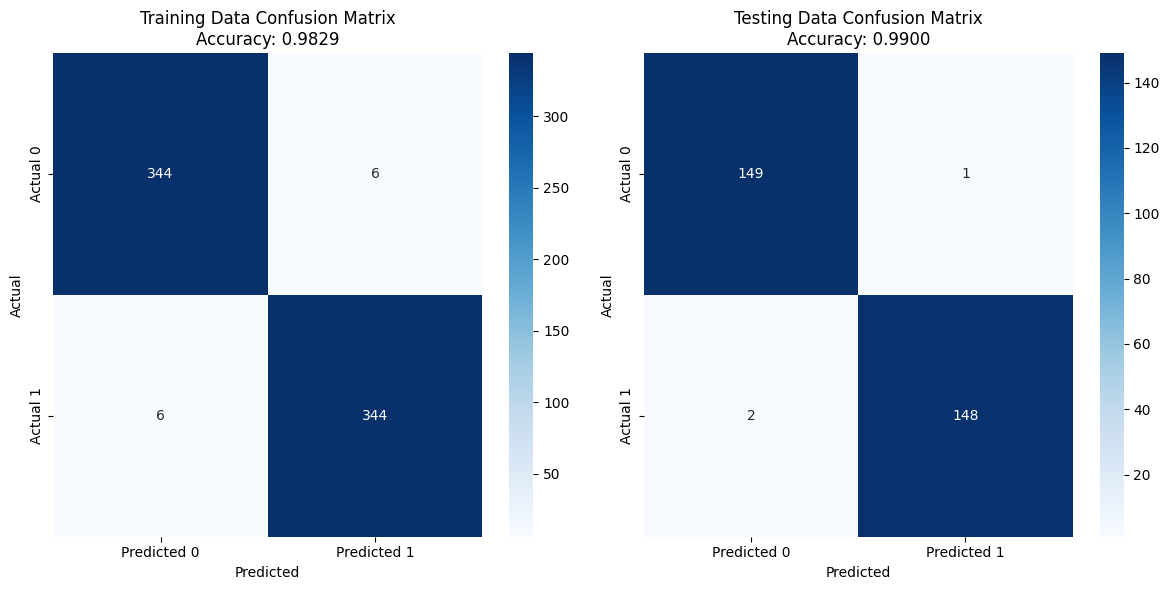

Training Data Accuracy: 0.9829
Testing Data Accuracy: 0.9900


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# Create the feature matrix X using relevant signature terms, including higher-order terms
# Let's assume 'X_train' and 'X_test' are the full feature matrices (with signature terms up to order 2)

# Add S(1,2), S(2,1), and S(2,2) to the feature set
X_train_selected = np.array([X_train[:, 1], X_train[:, 2], X_train[:, 3]]).T  # S(1,2), S(2,1), S(2,2) features for training
X_test_selected = np.array([X_test[:, 1], X_test[:, 2], X_test[:, 3]]).T  # S(1,2), S(2,1), S(2,2) features for testing

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Initialize and train the logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Predict on the training and testing data
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

# Confusion matrix for training data
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
accuracy_train = accuracy_score(y_train, y_train_pred)

# Confusion matrix for testing data
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

# Plot confusion matrices
plt.figure(figsize=(12, 6))

# Plot confusion matrix for training data
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title(f'Training Data Confusion Matrix\nAccuracy: {accuracy_train:.4f}')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot confusion matrix for testing data
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title(f'Testing Data Confusion Matrix\nAccuracy: {accuracy_test:.4f}')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Print the accuracy for both training and testing datasets
print(f'Training Data Accuracy: {accuracy_train:.4f}')
print(f'Testing Data Accuracy: {accuracy_test:.4f}')

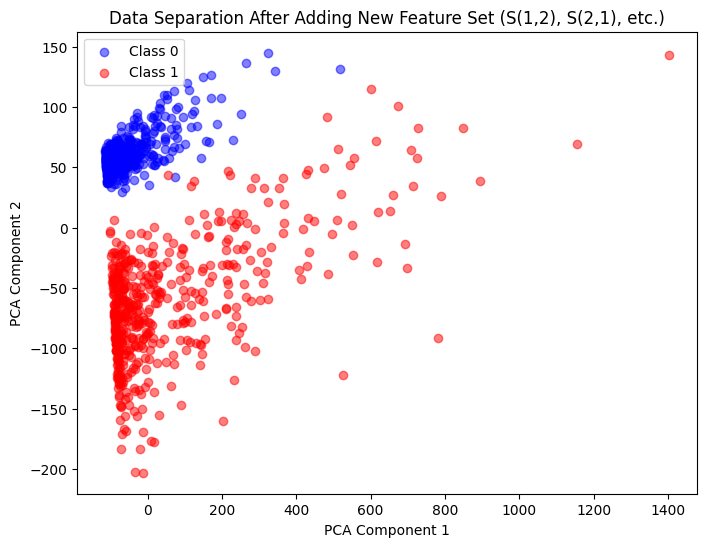

In [ ]:
# Import required libraries
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Create a feature matrix with the selected signature terms (S(1,2) and S(2,1) along with other terms)
X_selected = X[:, [1, 2, 3, 4]]  # assuming S(1,2), S(2,1), and others are at these indices

# Apply PCA for dimensionality reduction to 2D for easy plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_selected)

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], c='blue', label='Class 0', alpha=0.5)
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], c='red', label='Class 1', alpha=0.5)

# Add labels and title
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Data Separation After Adding New Feature Set (S(1,2), S(2,1), etc.)')
plt.legend()
plt.show()

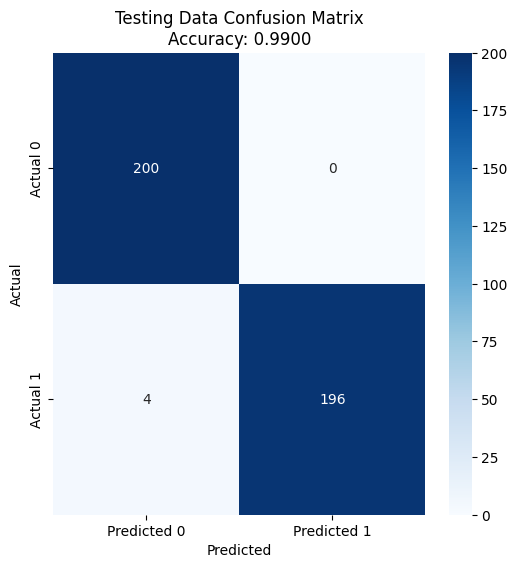

Testing Data Accuracy: 0.9900


In [ ]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import iisignature

# Parameters (same as before)
num_series = 500  # number of time series per class
length = 100      # length of each time series
noise_std = 1.0   # standard deviation of noise Z_t
signature_level = 2  # Signature truncation level

# AR(2) coefficients for each class
ar_coef_class0 = [-0.5, 0.25]
ar_coef_class1 = [0.75, -0.5]

# Function to generate AR(2) time series
def generate_ar_series(ar_coefs, length, noise_std):
    """ Generate a single AR(2) time series """
    p = len(ar_coefs)
    series = np.zeros(length)
    for t in range(p, length):
        series[t] = sum(ar_coefs[i] * series[t - i - 1] for i in range(p)) + np.random.normal(scale=noise_std)
    return series

# Lead-lag transformation function
def lead_lag_transform(series):
    """ Compute the lead-lag transformation of a time series """
    lead = np.cumsum(series)  # Cumulative sum transformation
    lag = np.insert(lead[:-1], 0, 0)  # Shifted version with an initial 0
    return np.vstack((lead, lag)).T  # Shape (length, 2)

# Compute signatures
def compute_signatures(series_list):
    """ Compute the signature of each transformed time series """
    sig_dim = iisignature.siglength(2, signature_level)
    signatures = np.zeros((len(series_list), sig_dim))

    for i, series in enumerate(series_list):
        transformed_path = lead_lag_transform(series)
        signatures[i] = iisignature.sig(transformed_path, signature_level)

    return signatures

# Generate training data
num_train_series = 500  # number of time series per class for training
series_class0 = [generate_ar_series(ar_coef_class0, length, noise_std) for _ in range(num_train_series)]
series_class1 = [generate_ar_series(ar_coef_class1, length, noise_std) for _ in range(num_train_series)]

# Compute signatures for the training data
signatures_class0 = compute_signatures(series_class0)
signatures_class1 = compute_signatures(series_class1)

# Combine data and standardize for training
X_train = np.vstack((signatures_class0, signatures_class1))
y_train = np.hstack((np.zeros(num_train_series), np.ones(num_train_series)))  # Class labels

# Standardization (Training Data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Train logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Generate additional testing time series for both classes (new test cases)
num_test_series = 200  # number of new time series per class for testing

# Generate new time series for both classes
test_series_class0 = [generate_ar_series(ar_coef_class0, length, noise_std) for _ in range(num_test_series)]
test_series_class1 = [generate_ar_series(ar_coef_class1, length, noise_std) for _ in range(num_test_series)]

# Compute signatures for the new testing data
test_signatures_class0 = compute_signatures(test_series_class0)
test_signatures_class1 = compute_signatures(test_series_class1)

# Combine test data and standardize
X_test = np.vstack((test_signatures_class0, test_signatures_class1))
y_test = np.hstack((np.zeros(num_test_series), np.ones(num_test_series)))  # Class labels for test

# Standardization (same scaler as training data)
X_test_scaled = scaler.transform(X_test)

# Predict on the test data
y_test_pred = log_reg.predict(X_test_scaled)

# Calculate confusion matrix and accuracy for testing data
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

# Plot confusion matrix for test data
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title(f'Testing Data Confusion Matrix\nAccuracy: {accuracy_test:.4f}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print the accuracy for the testing dataset
print(f'Testing Data Accuracy: {accuracy_test:.4f}')